In [2]:
!pip install -q spotipy scikit-learn pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.9/268.9 kB 15.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [5]:
# 0) Load dataset
print("Loading dataset...")
df = pd.read_csv('dataset.csv')
print(df.head())
print(f"Dataset loaded with {len(df)} tracks.\n")

Loading dataset...
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       2

In [6]:
# 1) Define features & train/test split
features = ['tempo','danceability','energy','valence',
            'acousticness','instrumentalness','loudness',
            'speechiness','liveness']
train_df, test_df = train_test_split(df, test_size=0.7, random_state=42)
print(f"Training set: {len(train_df)} tracks, Test set: {len(test_df)} tracks.\n")

Training set: 34200 tracks, Test set: 79800 tracks.



In [7]:
# 2) Scale features
scaler = StandardScaler().fit(train_df[features])
train_scaled = scaler.transform(train_df[features])
print("Features scaled.\n")

Features scaled.



Optimal k chosen = 7 (max silhouette = 0.198).



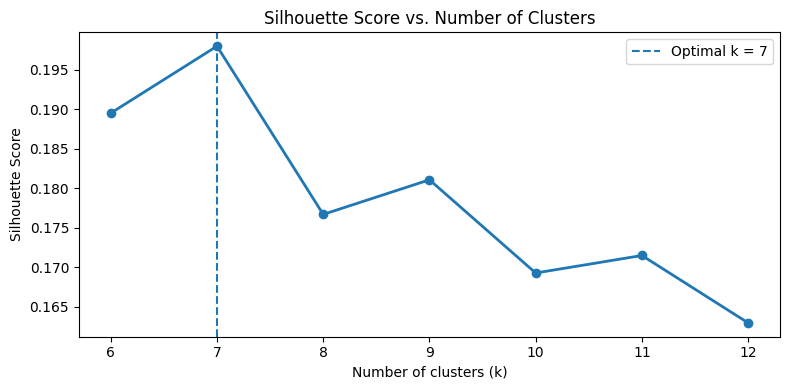

In [9]:
# 3) Determine optimal k automatically via silhouette
k_candidates = list(range(6, 13))
sil_scores = []
for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42).fit(train_scaled)
    sil_scores.append(silhouette_score(train_scaled, km.labels_))

optimal_k = k_candidates[np.argmax(sil_scores)]
print(f"Optimal k chosen = {optimal_k} (max silhouette = {max(sil_scores):.3f}).\n")

plt.figure(figsize=(8, 4))
plt.plot(k_candidates, sil_scores, marker='o', linewidth=2)
plt.axvline(optimal_k, linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_candidates)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
optimal_k=7
# 4) Train final model and assign clusters
final_km = KMeans(n_clusters=optimal_k, random_state=42).fit(train_scaled)
train_df['cluster'] = final_km.labels_
# Assign clusters to test set (for evaluation if needed)
test_scaled = scaler.transform(test_df[features])
test_df['cluster'] = final_km.predict(test_scaled)
print(f"Final KMeans trained with k={optimal_k}.\n")

Final KMeans trained with k=7.



In [ ]:
# 5) Recommendation functions

def recommend_cluster(seed_ids, df_base, n_recs=10):
    seeds = df_base[df_base['track_id'].isin(seed_ids)]
    profile = scaler.transform(seeds[features]).mean(axis=0)

    pool = df_base[df_base['cluster'].isin(seeds['cluster'].unique())]
    pool = pool[~pool['track_id'].isin(seed_ids)].copy()
    pool['distance'] = np.linalg.norm(scaler.transform(pool[features]) - profile, axis=1)

    # sort by distance, drop duplicates, then take top n
    deduped = (
        pool
        .sort_values('distance')
        .drop_duplicates(subset=['track_id', 'track_name'])
        .head(n_recs)
    )
    return deduped[['track_id','track_name','artists','cluster'] + features + ['distance']]


def recommend_whole(seed_ids, df_base, n_recs=10):
    seeds = df_base[df_base['track_id'].isin(seed_ids)]
    profile = scaler.transform(seeds[features]).mean(axis=0)

    pool = df_base[~df_base['track_id'].isin(seed_ids)].copy()
    pool['distance'] = np.linalg.norm(scaler.transform(pool[features]) - profile, axis=1)

    deduped = (
        pool
        .sort_values('distance')
        .drop_duplicates(subset=['track_id', 'track_name'])
        .head(n_recs)
    )
    return deduped[['track_id','track_name','artists'] + features + ['distance']]


def recommend_random(seed_ids, df_base, n_recs=10):
    seeds = df_base[df_base['track_id'].isin(seed_ids)]
    profile = scaler.transform(seeds[features]).mean(axis=0)

    pool = df_base[~df_base['track_id'].isin(seed_ids)].copy()
    sample_ids = np.random.choice(pool['track_id'], size=n_recs*2, replace=False)
    recs = pool[pool['track_id'].isin(sample_ids)].copy()
    recs['distance'] = np.linalg.norm(scaler.transform(recs[features]) - profile, axis=1)

    # sort, dedupe, then take top n
    deduped = (
        recs
        .sort_values('distance')
        .drop_duplicates(subset=['track_id', 'track_name'])
        .head(n_recs)
    )
    return deduped[['track_id','track_name','artists'] + features + ['distance']]

In [ ]:
from sklearn.neighbors import NearestNeighbors

# 1) canonicalize & dedupe helper
def _dedupe_df(df, name_col='track_name'):
    # normalize to lowercase, strip whitespace
    df = df.copy()
    df['_canon'] = (df[name_col]
                       .str.lower()
                       .str.strip()
                       .str.replace(r'\s+', ' ', regex=True))
    return df.drop_duplicates(subset=['_canon']).drop(columns=['_canon'])

# 2a) Random baseline
def make_random_playlist(df_base, size=10, seed=None):
    # drop duplicates up‐front
    df = _dedupe_df(df_base, 'track_name')
    return df['track_id'].sample(min(size, len(df)),
                                 random_state=seed)\
             .tolist()

# 2b) Cluster‐centric
cluster_probs = train_df['cluster'].value_counts(normalize=True)
def make_cluster_playlist(df_base, cluster_probs, size=10):
    chosen = np.random.choice(cluster_probs.index, p=cluster_probs.values)
    pool   = df_base[df_base['cluster']==chosen]
    pool   = _dedupe_df(pool, 'track_name')
    return pool['track_id']\
             .sample(min(size, len(pool)))\
             .tolist()

# 2c) KNN‐taste
nn        = NearestNeighbors(n_neighbors=30).fit(train_scaled)
track_ids = train_df['track_id'].values

def make_knn_playlist(seed_id, df_base, nn, track_ids, size=10):
    # 1) get seed vector
    vec = scaler.transform(
        df_base.loc[df_base['track_id']==seed_id, features]
    )
    # 2) ask for some extra neighbors
    n_neigh = size + 5
    dists, idxs = nn.kneighbors(vec, n_neighbors=n_neigh)
    # 3) flatten & drop the seed
    candidates = [
        (track_ids[i], float(d))
        for i, d in zip(idxs.flatten(), dists.flatten())
        if track_ids[i] != seed_id
    ]
    # 4) build a small DataFrame of (track_id, distance), merge in names
    df_cand = (
        pd.DataFrame(candidates, columns=['track_id','distance'])
          .merge(df_base[['track_id','track_name','artists']],
                 on='track_id', how='left')
    )
    # 5) canonicalize + drop duplicate names
    df_cand = _dedupe_df(df_cand, 'track_name')
    # 6) sort by true distance & take top `size`
    df_cand = df_cand.sort_values('distance').head(size)
    return df_cand['track_id'].tolist()

# 3) assemble 9 playlists
playlists = []
size = 10

#   3× random
for i in range(3):
    playlists.append(make_random_playlist(test_df, size, seed=100+i))

#   3× cluster
for _ in range(3):
    playlists.append(make_cluster_playlist(train_df, cluster_probs, size))

#   3× knn (random seeds)
seed_samples = train_df['track_id'].sample(3, random_state=0).tolist()
for s in seed_samples:
    playlists.append(make_knn_playlist(s, train_df, nn, track_ids, size))

# Containers for metrics
dist_records = []  # to collect distance metrics for plotting
radar_profiles = []
all_points = []  # for PCA scatter

In [ ]:
# 7) Process each playlist and display
for idx, seed_ids in enumerate(playlists, start=1):
    print(f"\n=== PLAYLIST {idx} SEED TRACKS ===")
    seed_tracks = df[df['track_id'].isin(seed_ids)][['track_name','artists'] + features]
    print(seed_tracks.to_string(index=False))

    # Cluster-based
    cl_recs = recommend_cluster(seed_ids, train_df)
    cl_cols = ['track_name','artists','cluster','distance'] + features
    print(f"\nCluster-based Recommendations:")
    print(cl_recs[cl_cols].to_string(index=False))
    for d in cl_recs['distance']:
        dist_records.append({'playlist': idx, 'method': 'cluster', 'distance': d})

    # Whole-library
    wl_recs = recommend_whole(seed_ids, train_df)
    wl_cols = ['track_name','artists','distance'] + features
    print(f"\nWhole-library Recommendations:")
    print(wl_recs[wl_cols].to_string(index=False))
    for d in wl_recs['distance']:
        dist_records.append({'playlist': idx, 'method': 'whole', 'distance': d})

    # Random baseline
    rnd_recs = recommend_random(seed_ids, train_df)
    rnd_cols = ['track_name','artists','distance'] + features
    print(f"\nRandom Baseline Recommendations:")
    print(rnd_recs[rnd_cols].to_string(index=False))
    for d in rnd_recs['distance']:
        dist_records.append({'playlist': idx, 'method': 'random', 'distance': d})


=== PLAYLIST 1 SEED TRACKS ===
                track_name                                                            artists   tempo  danceability  energy  valence  acousticness  instrumentalness  loudness  speechiness  liveness
         Cried Like A Baby                                                         Rory Block 179.760         0.704   0.488    0.745        0.5600          0.000016    -7.890       0.0390    0.0811
    Las Trémulas Canciones                                                          Estelares 113.023         0.739   0.679    0.772        0.1570          0.000003    -4.918       0.0261    0.0405
I don't see nobody but you                                                              Yusei 107.015         0.576   0.355    0.332        0.9750          0.801000    -8.983       0.1050    0.1100
  One Kiss (with Dua Lipa)                                             Calvin Harris;Dua Lipa 123.994         0.791   0.862    0.592        0.0370          0.000022    -3.240  

<ipython-input-165-16d4a0671ac5>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


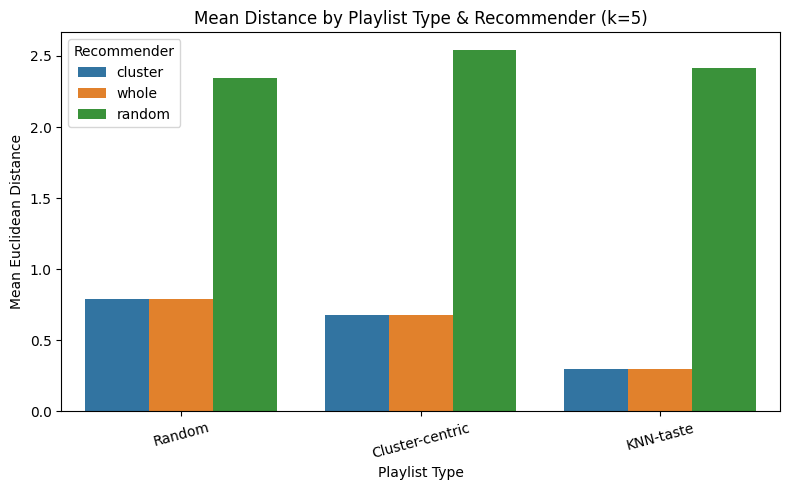

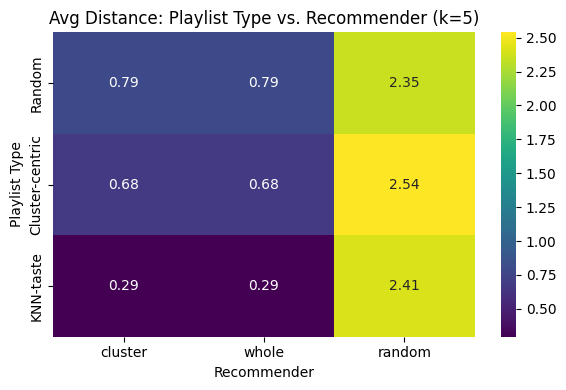

In [ ]:
metrics_df = pd.DataFrame(dist_records)

# Map playlist → type
playlist_types = ['Random']*3 + ['Cluster-centric']*3 + ['KNN-taste']*3
type_map = {pid+1: ptype for pid, ptype in enumerate(playlist_types)}
metrics_df['playlist_type'] = metrics_df['playlist'].map(type_map)

# Bar chart of mean distance
methods = ['cluster','whole','random']
order_types = ['Random','Cluster-centric','KNN-taste']

plt.figure(figsize=(8,5))
sns.barplot(
    x='playlist_type',
    y='distance',
    hue='method',
    data=metrics_df[metrics_df['method'].isin(methods)],
    order=order_types,
    estimator=np.mean,
    ci=None
)
plt.title('Mean Distance by Playlist Type & Recommender (k=5)')
plt.ylabel('Mean Euclidean Distance')
plt.xlabel('Playlist Type')
plt.xticks(rotation=15)
plt.legend(title='Recommender')
plt.tight_layout()
plt.show()

# Heatmap of average distance
heat2 = metrics_df.pivot_table(
    index='playlist_type',
    columns='method',
    values='distance',
    aggfunc='mean'
).loc[order_types, methods]

plt.figure(figsize=(6,4))
sns.heatmap(heat2, annot=True, fmt='.2f', cmap='viridis')
plt.title('Avg Distance: Playlist Type vs. Recommender (k=5)')
plt.ylabel('Playlist Type')
plt.xlabel('Recommender')
plt.tight_layout()
plt.show()